In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, manifold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import sklearn.metrics as le_me
from itertools import permutations
from tqdm import tqdm
import pickle 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def data_load():
    dat = pd.read_csv("./chen_dat/GSE96058_sorted_ki67_16889.csv", index_col = 0)
    # Small - GSE81538_sorted_ki67_16889.csv
    # Large - GSE96058_sorted_ki67_16889.csv
    # Label - GeneOrder_16889.txt
    col_names = list(dat.columns)
    col_names[0] = "output"
    dat.columns = [col_names]
    return(dat)

def train_test_splitting(data):
    dat = data.copy()
    # train test split
    #X = dat.loc[:, dat.columns != 'output']
    X = dat.drop(['output'], axis=1)
    y = dat['output']

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
    #y_train = to_categorical(list(y_train))
    #y_non_transformed = list(y_test)
    #y_test = to_categorical(list(y_test))

    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    sc=StandardScaler()

    scaler = sc.fit(X_train)
    trainX_scaled = scaler.transform(X_train)
    testX_scaled = scaler.transform(X_test)
    
    return(trainX_scaled, testX_scaled,y_train,y_test)

def training_inital_plot(X_train, y_train):
    # simple PCA plot
    pca = decomposition.PCA(n_components=2)
    pca.fit(X_train)
    pca_out = pca.transform(X_train)

    colors = list()
    for i in range(len(list(y_train))):
        if (list(y_train)[i] == 1):
            colors.append('red')
        elif (list(y_train)[i] == 0):
            colors.append('green')

    fig = plt.figure(1)
    fig.suptitle('PCA visualization of training data')
    ax = fig.add_subplot(111)
    ax.scatter(pca_out[:,0], pca_out[:,1], c=colors, alpha = 0.5)
    m1, = plt.plot(np.nan, np.nan, c='red', linestyle='None', marker='o', label='1', alpha=1)
    m2, = plt.plot(np.nan, np.nan, c='green', linestyle='None', marker='o', label="0", alpha=1)

    plt.legend(handles=[m1, m2], loc='best')
    plt.show()

    # TSNE plot
    tsne = manifold.TSNE(n_components=2, init='pca', n_iter=15000)
    tsne_out = tsne.fit_transform(X_train)
    fig = plt.figure(2)
    fig.suptitle('t-SNE visualization of training data')
    ax = fig.add_subplot(111)
    ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=colors, alpha=0.5)
    m1, = plt.plot(np.nan, np.nan, c='red', linestyle='None', marker='o', label='1', alpha=1)
    m2, = plt.plot(np.nan, np.nan, c='green', linestyle='None', marker='o', label="0", alpha=1)
    plt.legend(handles=[m1, m2], loc='best')
    plt.show()

def plot_perfomance(y_test, p_in):
    # get tpr and fpr curves & AUC values
    preds = p_in
    y_valid_reshaped = y_test
    fpr, tpr, thres = le_me.roc_curve(y_valid_reshaped, preds)
    roc_auc = le_me.roc_auc_score(y_valid_reshaped, preds)


    # plot AUROC Curves
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax = axes.ravel()

    ax[0].plot(fpr,tpr, color="blue", 
            label="MLP       (%0.4f)" % roc_auc, alpha= 1)
    ax[0].plot([0, 1], [0, 1], color="grey", linestyle="--",
            label="Baseline (0.50)")
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.0])
    ax[0].set_xlabel("1-specificity")
    ax[0].set_ylabel("sensitivity")
    ax[0].set_title("ROC Curve")
    ax[0].legend()


    # get precisions and recalls and AUPRC
    precision, recall, _ = le_me.precision_recall_curve(y_valid_reshaped, preds)
    pr_auc = le_me.auc(recall, precision)
    
    # Plot AUPRC
    ax[1].plot(recall,precision, color="blue", 
            label="MLP       (%0.4f)" % pr_auc,alpha= 1)
    ax[1].plot([0, 1], [np.mean(y_valid_reshaped), np.mean(y_valid_reshaped)], color="grey", linestyle="--",
            label="Baseline (%0.2f)" % np.mean(y_valid_reshaped))
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0]) #0.45
    ax[1].set_xlabel("recall")
    ax[1].set_ylabel("precision")
    ax[1].set_title("PR Curve")
    ax[1].legend()

    plt.show()

def permutation_importance(model, X_train, y_train, X_test, y_test, num_permutations=100):
    """
    Computes feature importance using permutation testing.

    Parameters:
    - model: a machine learning model
    - X_train: training input data
    - y_train: training target data
    - X_test: testing input data
    - y_test: testing target data
    - num_permutations: number of permutations to run (default=100)

    Returns:
    - imp_scores: a dictionary containing feature importance scores
    """

    # Train the model and calculate initial accuracy
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    initial_acc = accuracy_score(y_test, y_pred)

    # Create a list of features
    features = list(range(X_train.shape[1]))

    # Compute feature importance scores using permutation testing
    imp_scores = {}
    for k in range(num_permutations):
        imp_scores[k] = {}
        for perm in permutations(features):
            # Permute the selected feature
            X_perm = X_test.copy()
            for i, j in enumerate(perm):
                X_perm[:, i] = X_test[:, j]

            # Compute accuracy on permuted data
            y_perm_pred = model.predict(X_perm)
            acc_perm = accuracy_score(y_test, y_perm_pred)

            # Compute the difference in accuracy
            diff = initial_acc - acc_perm

            # Store the importance score for the current feature
            for j, f in enumerate(perm):
                if f not in imp_scores[k]:
                    imp_scores[k][f] = []
                imp_scores[k][f].append(diff)

    # Compute average importance score for each feature
    for f in features:
        imp_scores[f] = np.mean([np.mean(imp_scores[k][f]) for k in range(num_permutations)])

    return imp_scores

def show_accuracy(model, x_test, x_train, y_test_in, y_train_in):
    y_pred = model.predict(x_test)
    print('Test Accuracy: {:.2f}'.format(accuracy_score(y_test_in, y_pred)))
    preds_prob = model.predict_proba(x_test)
    preds_prob = [item[1] for item in preds_prob]
    y_pred_r2 = le_me.r2_score(y_test, preds_prob) 


    y_pred_train = model.predict(x_train)
    print('Train Accuracy: {:.2f}'.format(accuracy_score(y_train_in, y_pred_train)))
    preds_prob_train = model.predict_proba(x_train)
    preds_prob_train = [item[1] for item in preds_prob_train]
    y_pred_r2_train = le_me.r2_score(y_train, preds_prob_train) 

    pred_1 = [preds_prob[i] for i in list(np.where(y_test == 1)[0])]
    pred_0 = [preds_prob[i] for i in list(np.where(y_test == 0)[0])]
    #plt.hist(pred_1, bins=40, alpha=0.3, label='0', color = 'blue')
    #plt.hist(pred_0, bins=40, alpha=0.3, label='1', color = 'red')
    plt.hist([pred_1, pred_0], bins=20, label=['1', '0'], color=['red', 'blue'])
    plt.ylabel('count', fontsize=10)
    plt.xlabel('predicted probability', fontsize=10)
    plt.legend(loc='upper right')
    plt.show()

(1363, 16890)


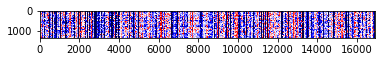

In [3]:
dat = data_load()
print(dat.shape)
plt.imshow(dat, cmap='seismic', interpolation='nearest')

In [4]:
dat

,output,OR4F5.rescaled,SAMD11.rescaled,NOC2L.rescaled,KLHL17.rescaled,PLEKHN1.rescaled,HES4.rescaled,ISG15.rescaled,AGRN.rescaled,RNF223.rescaled,...,RBMY1E.rescaled,RBMY1F.rescaled,RBMY1J.rescaled,PRY.rescaled,BPY2.rescaled,DAZ1.rescaled,DAZ2.rescaled,DAZ3.rescaled,DAZ4.rescaled,CDY1.rescaled
sampleID,,,,,,,,,,,,,,,,,,,,,
F1000,1,0,0.288676,0.332762,0.419961,0.250692,0.466842,0.298180,0.430575,0.319008,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
F1001,1,0,0.398067,0.379095,0.480371,0.592306,0.613020,0.419970,0.664952,0.588062,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
F1002,1,0,0.665585,0.398630,0.587222,0.647240,0.686654,0.411771,0.534296,0.541425,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
F1003,1,0,0.354397,0.492948,0.607472,0.437989,0.544653,0.405733,0.480609,0.438507,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
F1004,1,0,0.296835,0.367540,0.497037,0.271532,0.739810,0.332564,0.350593,0.000000,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F995,1,0,0.346371,0.457465,0.644114,0.673112,0.673813,0.492795,0.606088,0.589057,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
F996,1,0,0.159850,0.171519,0.426584,0.244294,0.503036,0.498190,0.433600,0.431729,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5
F997,0,0,0.430354,0.351739,0.666296,0.552140,0.561481,0.270194,0.663088,0.479253,...,0,0.5,0.5,0,0.5,0.5,0.5,0.5,0.5,0.5


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_22525/1693410113.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = dat.drop(['output'], axis=1)


(1090, 16889) (1090,)
(273, 16889) (273,)


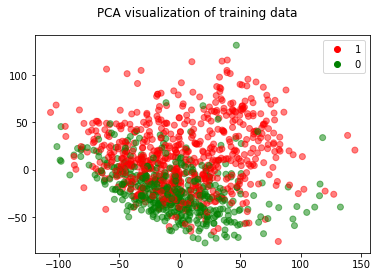

/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


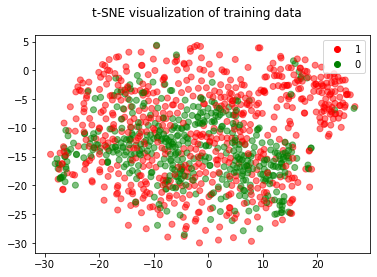

In [5]:
x_train, x_test, y_train, y_test = train_test_splitting(dat)
training_inital_plot(x_train, y_train)

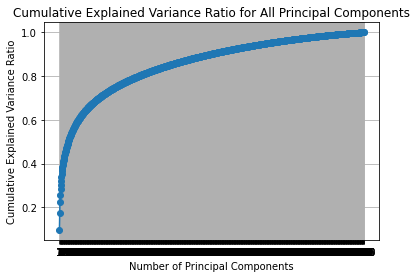

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_cumulative_variance(train_x):
    # Perform PCA on the training data
    pca = PCA()
    pca.fit(train_x)

    # Calculate cumulative explained variance ratio
    cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative explained variance ratio
    num_components = len(pca.explained_variance_)
    plt.plot(range(1, num_components + 1), cum_var_ratio, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio for All Principal Components')
    plt.xticks(range(1, num_components + 1))
    plt.grid(True)
    plt.show()

plot_cumulative_variance(x_train)


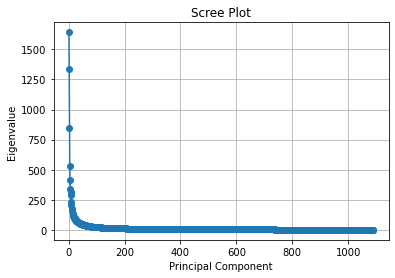

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_scree_plot(train_x):
    # Perform PCA on the training data
    pca = PCA()
    pca.fit(train_x)

    # Get the eigenvalues (explained variance) of each principal component
    eigenvalues = pca.explained_variance_

    # Plot the scree plot
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.title('Scree Plot')
    plt.grid(True)
    plt.show()


plot_scree_plot(x_train)


In [8]:
# param_grid = {
#     'hidden_layer_sizes': [(64, 128, 128, 64, 32, 16)], #(64, 128, 128, 64, 32, 16)
#     'activation': ['logistic', 'relu'],
#     'alpha':[0.1, 0.05, 0.25],
#     'learning_rate': ['adaptive']
# }

# def run_mlp_grid_search_cv(X, y, param_grid):
#     """
#     Performs 5-fold cross-validation on a grid search of an MLPClassifier
#     with many parameters for classification, and returns the best model and
#     its performance.

#     Parameters
#     ----------
#     X : array-like of shape (n_samples, n_features)
#         The input data.

#     y : array-like of shape (n_samples,)
#         The binary class labels.

#     param_grid : dict
#         The parameter grid to search over, where the keys are parameter names
#         and the values are lists of parameter settings to try.

#     Returns
#     -------
#     best_model : MLPClassifier
#         The best MLPClassifier model found by the grid search.

#     report : str
#         The classification report of the best model on the test set.

#     """

#     # Create an MLPClassifier object
#     mlp = MLPClassifier()

#     # Create a GridSearchCV #object with 5-fold cross-validation
#     grid_search = GridSearchCV(
#         mlp, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=10
#     )

#     # Fit the GridSearchCV object to the data
#     grid_search.fit(X, y)

#     # Get the best MLPClassifier model
#     best_model = grid_search.best_estimator_

#     # Get the classification report of the best model on the test set
#     y_true, y_pred = y, best_model.predict(X)
#     report = classification_report(y_true, y_pred, output_dict=True)

#     return best_model, report

In [9]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report

# param_grid = {
#     'hidden_layer_sizes': [(64, 128, 128, 64, 32, 16), (64, 128, 128, 64)], #(64, 128, 128, 64, 32, 16)
#     'activation': ['logistic', 'relu'],
#     'alpha': [0.1, 0.05, 0.25],
#     'learning_rate': ['adaptive']
# }

# # Create an MLPClassifier object
# mlp = MLPClassifier()

# # Create a GridSearchCV object with 5-fold cross-validation
# grid_search = GridSearchCV(
#     mlp, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=10
# )

# # Fit the GridSearchCV object to the data
# grid_search.fit(x_train, y_train)

# # Get the best MLPClassifier model
# #ml_1 = grid_search.best_estimator_
# ml_1 = grid_search.best_estimator_.fit(x_train,y_train)
 
# # Get the classification report of the best model on the test set
# y_true, y_pred = y_train, ml_1.predict(x_train)
# report = classification_report(y_true, y_pred, output_dict=True)


In [10]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    'hidden_layer_sizes': [(64, 128, 128, 64, 32, 16), (64, 128, 128, 64)], #(64, 128, 128, 64, 32, 16)
    'activation': ['logistic', 'relu'],
    'alpha': [0.1, 0.05, 0.25],
    'learning_rate': ['adaptive'],
    'max_iter': [100, 200, 1000] 

}


# Get the top x principal components
x = 100  # Specify the number of top principal components you want to use
pca = PCA(n_components=x)
top_principal_components_train = pca.fit_transform(x_train)
top_principal_components_test = pca.transform(x_test)

# Create an MLPClassifier object
mlp = MLPClassifier()

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(
    mlp, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=10
)

# Fit the GridSearchCV object to the top principal components and the labels
grid_search.fit(top_principal_components_train, y_train)

# Get the best MLPClassifier model
ml_1 = grid_search.best_estimator_

# Get the classification report of the best model on the training set
y_true, y_pred = y_train, ml_1.predict(top_principal_components_train)
report = classification_report(y_true, y_pred, output_dict=True)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/minicond

/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rstojsin/minicond

In [11]:
mlp_fin = grid_search.best_estimator_
mlp_fin.fit(top_principal_components_train,y_train)

/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.1,
              hidden_layer_sizes=(64, 128, 128, 64), learning_rate='adaptive')

In [12]:
print(pd.DataFrame(report).transpose())
pickle.dump(mlp_fin, open('./models/1_gene_selection_fin', 'wb'))
ml_1 = pickle.load(open('./models/1_gene_selection_fin', 'rb'))
y_true, y_pred = y_train, ml_1.predict(top_principal_components_train)
report = classification_report(y_true, y_pred, output_dict=True)
report

              precision  recall  f1-score  support
0                   1.0     1.0       1.0    454.0
1                   1.0     1.0       1.0    636.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1090.0
weighted avg        1.0     1.0       1.0   1090.0


{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 454},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 636},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1090},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 1090}}

In [13]:
y_true_test, y_pred_test = y_test, ml_1.predict(top_principal_components_test)
report_test = classification_report(y_true_test, y_pred_test, output_dict=True)
report_test

{'0': {'precision': 0.696969696969697,
  'recall': 0.6052631578947368,
  'f1-score': 0.6478873239436619,
  'support': 114},
 '1': {'precision': 0.7413793103448276,
  'recall': 0.8113207547169812,
  'f1-score': 0.7747747747747747,
  'support': 159},
 'accuracy': 0.7252747252747253,
 'macro avg': {'precision': 0.7191745036572623,
  'recall': 0.708291956305859,
  'f1-score': 0.7113310493592183,
  'support': 273},
 'weighted avg': {'precision': 0.7228346366277402,
  'recall': 0.7252747252747253,
  'f1-score': 0.7217888062958485,
  'support': 273}}

In [14]:
y_pred = ml_1.predict(top_principal_components_test)
print('Test Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
preds_prob = ml_1.predict_proba(top_principal_components_test)
preds_prob = [item[1] for item in preds_prob]
y_pred_r2 = le_me.r2_score(y_test, preds_prob) 

y_pred_train = ml_1.predict(top_principal_components_train)
print('Train Accuracy: {:.2f}'.format(accuracy_score(y_train, y_pred_train)))
preds_prob_train = ml_1.predict_proba(top_principal_components_train)
preds_prob_train = [item[1] for item in preds_prob_train]
y_pred_r2_train = le_me.r2_score(y_train, preds_prob_train) 

Test Accuracy: 0.73
Train Accuracy: 1.00


Test Accuracy: 0.73
Train Accuracy: 1.00


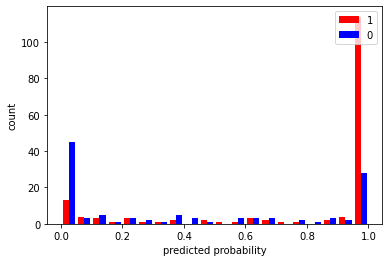

In [15]:
show_accuracy(ml_1, top_principal_components_test, top_principal_components_train, y_test, y_train)


/Users/rstojsin/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


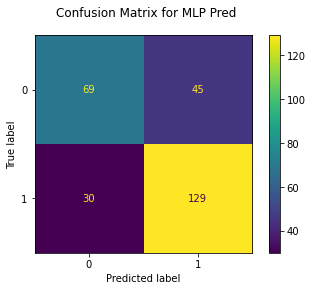

In [16]:
fig = plot_confusion_matrix(ml_1, top_principal_components_test, y_test, display_labels=ml_1.classes_)
fig.figure_.suptitle("Confusion Matrix for MLP Pred")
plt.show()

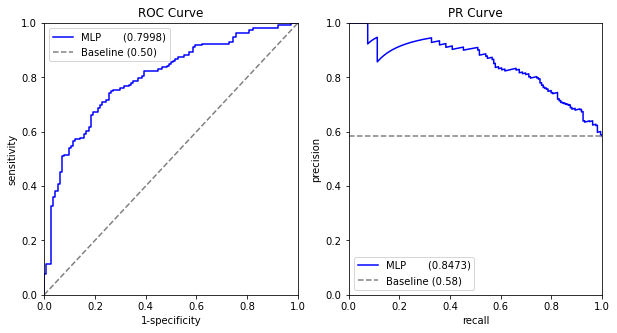

In [17]:
plot_perfomance(y_test, preds_prob)

In [18]:
# def cv_evaluation(model, X, y, folds =5):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
#     skf = StratifiedKFold(n_splits=folds, shuffle = True)
#     fig, axs = plt.subplots(1, 2, figsize=(12,6))
#     axs[0].set_title('Average ROC Curve')
#     axs[0].plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
#     axs[1].set_title('Average PR Curve')
#     precision_sum = 0
#     recall_sum = 0
#     f1_score_sum = 0
#     acc_sum = 0
#     tprs = []
#     aucs = []
#     mean_fpr = np.linspace(0, 1, 100)
#     print(X.shape)
#     print(len(y))
#     row_names = X.index.tolist()
#     X = np.array(X)
#     for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
#         train_index = list(train_index)
#         test_index = list(test_index)
# #         train_index_X = [row_names[index] for index in train_index]
# #         test_index_X = [row_names[index] for index in test_index]

#         #print(train_index_X)
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         y_train = y_train.reshape(-1)
#         y_test = y_test.reshape(-1)

#         #X_train = X_train.T
#         #X_test = X_test.T
#         model.fit(X_train, y_train)
#         y_pred_proba = model.predict_proba(X_test)[:, 1]
#         y_pred = np.round(y_pred_proba)
#         fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#         precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
#         tprs.append(np.interp(mean_fpr, fpr, tpr))
#         tprs[-1][0] = 0.0
#         roc_auc = auc(fpr, tpr)
#         aucs.append(roc_auc)
#         axs[0].plot(fpr, tpr, lw=1, alpha=.8, label='AUROC %d (%0.3f)' % (i+1, roc_auc))
#         axs[1].step(recall, precision, alpha=0.8, where='post', lw=1, label='AUPRC %d (%0.3f)' % (i+1, np.mean(precision)))

#         #axs[1].step(recall, precision, alpha=0.8, where='post')
#         avg_precision = average_precision_score(y_test, y_pred_proba)
#         precision_sum += avg_precision
#         recall_sum += np.mean(recall)
#         f1_score_sum += f1_score(y_test, np.round(y_pred_proba))
#         acc_sum += accuracy_score(y_test, y_pred)

#     axs[0].plot([0, 1], [0, 1], linestyle='--', color='grey')
#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
#     axs[0].plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (%0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)
#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     axs[0].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
#     axs[0].legend(loc='lower right')
#     axs[1].set_ylim([0, 1])
#     axs[1].plot([0, 1], [np.mean(y_train), np.mean(y_train)], color="grey", linestyle="--",
#             label="Baseline (%0.2f)" % np.mean(y_train))
#     axs[1].legend(loc='lower right')
#     axs[0].set_xlabel('False Positive Rate')
#     axs[0].set_ylabel('True Positive Rate')
#     axs[1].set_xlabel('Recall')
#     axs[1].set_ylabel('Precision')
#     precision_avg = precision_sum/folds
#     recall_avg = recall_sum/folds
#     f1_score_avg = f1_score_sum/folds
#     acc_avg = acc_sum/folds
#     print("average precision:",precision_avg)
#     print("average recall:   ",recall_avg)
#     print("average F1 Score: ",f1_score_avg)
#     print("average Accuracy: ",acc_avg)

In [19]:
# X = dat.drop(['output'], axis=1)
# y = dat['output']
# cv_evaluation(m_1, X, y.values, 5)

In [20]:
m_1 = pickle.load(open('./models/1_gene_selection_fin', 'rb'))
# m_1.fit(x_train,y_train)

y_pred = m_1.predict(top_principal_components_test)
print('Test Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
preds_prob = m_1.predict_proba(top_principal_components_test)
preds_prob = [item[1] for item in preds_prob]
y_pred_r2 = le_me.r2_score(y_test, preds_prob) 

y_pred_train = m_1.predict(top_principal_components_train)
print('Train Accuracy: {:.2f}'.format(accuracy_score(y_train, y_pred_train)))
preds_prob_train = m_1.predict_proba(top_principal_components_train)
preds_prob_train = [item[1] for item in preds_prob_train]
y_pred_r2_train = le_me.r2_score(y_train, preds_prob_train) 

Test Accuracy: 0.73
Train Accuracy: 1.00


100%|███████████████████████████████████| 16889/16889 [2:27:52<00:00,  1.90it/s]


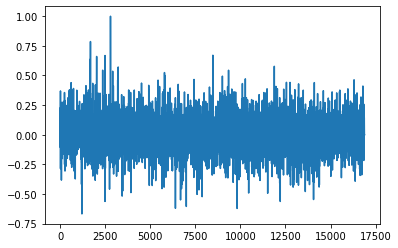

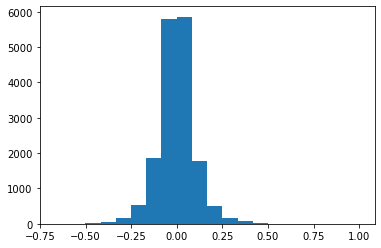

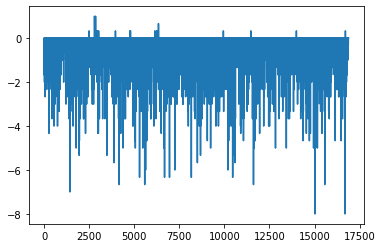

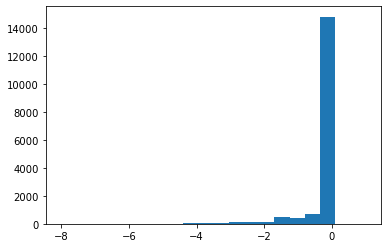

In [21]:
from joblib import Parallel, delayed
from tqdm import tqdm

s1 = accuracy_score(y_test, y_pred)
s2 = le_me.r2_score(y_test, preds_prob)

def get_feature_importance(j, n, X_test1, y_test_in, y_pred_in, y_pred_pr):
    total1 = 0.0
    total2 = 0.0
    for i in range(n):
        testX_scaled_eval = X_test1
        perm = np.random.permutation(range(testX_scaled_eval.shape[0]))
        X_test_ = testX_scaled_eval.copy()
        X_test_[:, j] = testX_scaled_eval[perm, j]
        X_test_ = pca.transform(X_test_)
        y_pred_1 = m_1.predict(X_test_)
        y_pred_2 = m_1.predict_proba(X_test_)
        y_pred_2 = [item[1] for item in y_pred_2]
        s_ij_1 = accuracy_score(y_test_in, y_pred_1)
        s_ij_2 = le_me.r2_score(y_test_in, y_pred_2)
        total1 += s_ij_1
        total2 += s_ij_2
    return (s1 - total1 / n), (s2 - total2 / n)

# Feature importances
number_perms_per_gene = 25
f_1 = []
f_2 = []

def process_feature(j):
    return get_feature_importance(j, number_perms_per_gene, x_test, y_test, y_pred, preds_prob)

results = Parallel(n_jobs=-1)(delayed(process_feature)(j) for j in tqdm(range(int(x_test.shape[1]))))

for result in results:
    f_1.append(result[0])
    f_2.append(result[1])

with open("./features_accuracy_25perm_fin_1", "wb") as fp:   #Pickling
    pickle.dump(f_1, fp)
    
with open("./features_rsquared_25perm_fin_1", "wb") as fp:   #Pickling
    pickle.dump(f_2, fp)
    
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_2) for i in f_2])
plt.show()
plt.hist([float(i)/max(f_2) for i in f_2], 20)
plt.show()
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_1) for i in f_1])
plt.show()
plt.hist([float(i)/max(f_1) for i in f_1], 20)
plt.show()

100%|███████████████████████████████████| 16889/16889 [2:25:19<00:00,  1.94it/s]


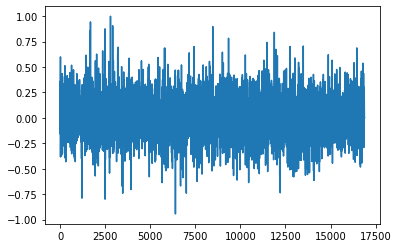

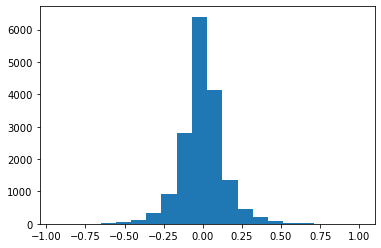

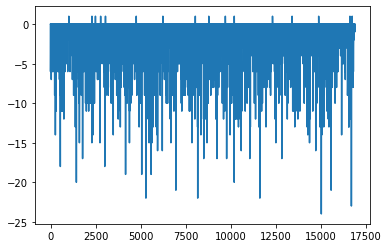

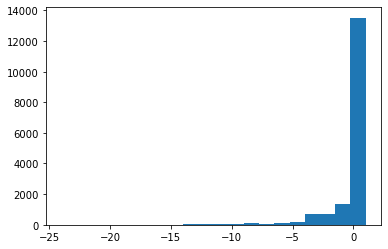

In [22]:
# Feature importances
number_perms_per_gene = 25
f_1 = []
f_2 = []

def process_feature(j):
    return get_feature_importance(j, number_perms_per_gene, x_test, y_test, y_pred, preds_prob)

results = Parallel(n_jobs=-1)(delayed(process_feature)(j) for j in tqdm(range(int(x_test.shape[1]))))

for result in results:
    f_1.append(result[0])
    f_2.append(result[1])

with open("./features_accuracy_25perm_fin_2", "wb") as fp:   #Pickling
    pickle.dump(f_1, fp)
    
with open("./features_rsquared_25perm_fin_2", "wb") as fp:   #Pickling
    pickle.dump(f_2, fp)
    
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_2) for i in f_2])
plt.show()
plt.hist([float(i)/max(f_2) for i in f_2], 20)
plt.show()
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_1) for i in f_1])
plt.show()
plt.hist([float(i)/max(f_1) for i in f_1], 20)
plt.show()

100%|███████████████████████████████████| 16889/16889 [2:23:19<00:00,  1.96it/s]


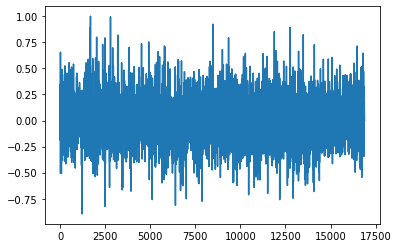

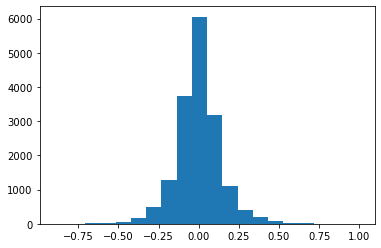

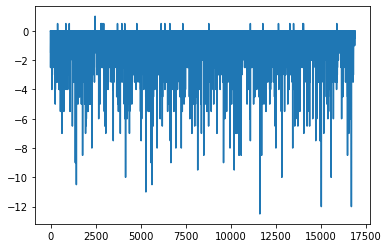

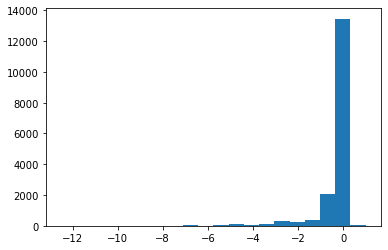

In [23]:
# Feature importances
number_perms_per_gene = 25
f_1 = []
f_2 = []

def process_feature(j):
    return get_feature_importance(j, number_perms_per_gene, x_test, y_test, y_pred, preds_prob)

results = Parallel(n_jobs=-1)(delayed(process_feature)(j) for j in tqdm(range(int(x_test.shape[1]))))

for result in results:
    f_1.append(result[0])
    f_2.append(result[1])

with open("./features_accuracy_25perm_fin_3", "wb") as fp:   #Pickling
    pickle.dump(f_1, fp)
    
with open("./features_rsquared_25perm_fin_3", "wb") as fp:   #Pickling
    pickle.dump(f_2, fp)
    
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_2) for i in f_2])
plt.show()
plt.hist([float(i)/max(f_2) for i in f_2], 20)
plt.show()
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_1) for i in f_1])
plt.show()
plt.hist([float(i)/max(f_1) for i in f_1], 20)
plt.show()

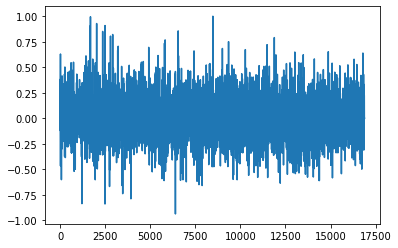

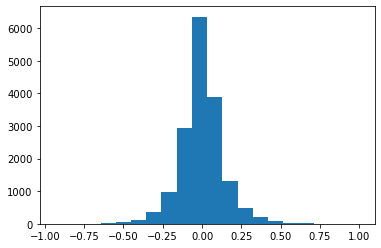

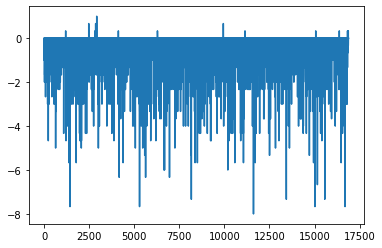

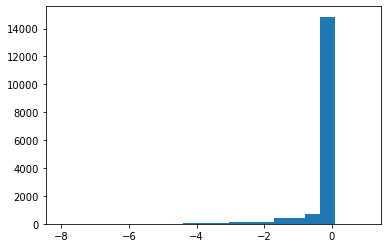

In [27]:
# Feature importances
number_perms_per_gene = 25
f_1 = []
f_2 = []

def process_feature(j):
    return get_feature_importance(j, number_perms_per_gene, x_test, y_test, y_pred, preds_prob)

results = Parallel(n_jobs=-1)(delayed(process_feature)(j) for j in tqdm(range(int(x_test.shape[1]))))

for result in results:
    f_1.append(result[0])
    f_2.append(result[1])

with open("./features_accuracy_25perm_fin_4", "wb") as fp:   #Pickling
    pickle.dump(f_1, fp)
    
with open("./features_rsquared_25perm_fin_4", "wb") as fp:   #Pickling
    pickle.dump(f_2, fp)
    
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_2) for i in f_2])
plt.show()
plt.hist([float(i)/max(f_2) for i in f_2], 20)
plt.show()
# 0 to 1 feature importances for all values
plt.plot([float(i)/max(f_1) for i in f_1])
plt.show()
plt.hist([float(i)/max(f_1) for i in f_1], 20)
plt.show()